In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from tqdm import tqdm

import time
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

In [2]:
# data loading

data_ver = '3'

# NOISE
with gzip.open(f'../data/segment_with_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_with_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open(f'../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open(f'../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
68268,274.111469,109.920335,0.00,5.87,152.640,0.634,1.101,0.47,0.36,0.60,0.237,-0.150,1,274.552482,109.713725
68293,272.808525,110.598795,-0.01,5.88,152.633,0.648,1.087,-0.81,1.00,-0.26,0.212,-0.143,1,272.908564,110.574182
68318,271.504469,111.278905,0.00,5.90,152.626,0.677,1.130,-0.01,-0.45,-0.20,0.320,-0.018,1,271.749154,111.113036
68343,270.195971,111.961492,-0.01,5.91,152.607,0.720,1.148,-1.15,-0.40,0.47,0.242,-0.473,1,270.756194,112.243151
68368,268.884140,112.646555,-0.01,5.93,152.600,0.716,1.147,0.52,-0.02,-0.34,0.054,-0.277,1,269.351030,112.376572


In [4]:
# sample_freq = 50 # 5hz
sample_freq = 25 # 10hz
dt = 0.01 * sample_freq

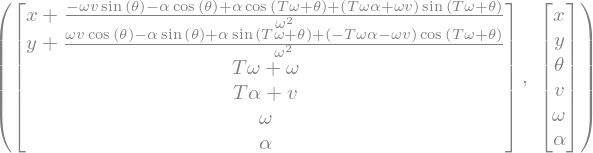

In [33]:
v, theta, omega, dts, x, y, lat, lon, alpha = symbols('v theta \omega T x y lat lon alpha')

# transition matrix
gs = Matrix([[x + (1 / omega**2) * ((v*omega + alpha * omega * dts) * sin(theta + omega * dts) + alpha * cos(theta + omega * dts) - v * omega * sin(theta) - alpha * cos(theta))],    
             [y + (1 / omega**2) * ((-v*omega - alpha * omega * dts) * cos(theta + omega * dts) + alpha * sin(theta + omega * dts) + v * omega * cos(theta) - alpha * sin(theta))],
             [omega + omega*dts],
             [a*dts + v],
             [omega],
             [alpha]])

# state vector             
state = Matrix([x, y, theta, v, omega, a])
gs, state

In [38]:
state

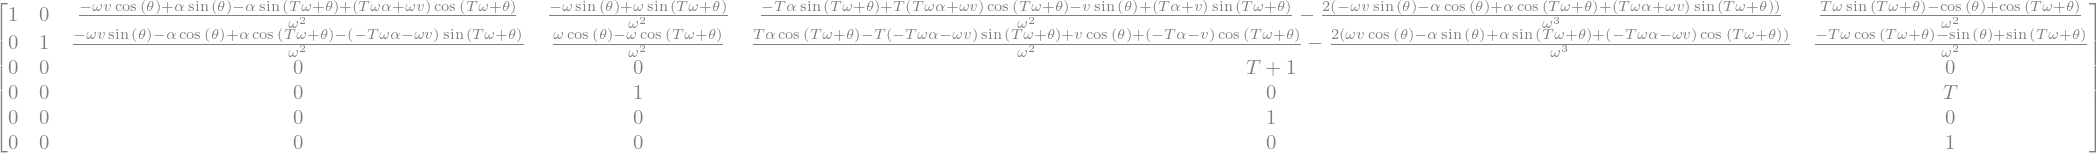

In [34]:
gs.jacobian(state)

In [32]:
# P0 matrix
P_init = 1 * np.eye(len(state))
print(P_init, P_init.shape)
print()

# Process noise covariance Q matrix
max_alpha_Vx = 2.193 # m/s
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 

# Measurement covariance R matrix
sig_gps = 0.25
sig_theta = 0*dt
sig_vel = 0*dt
sig_omega = 0*dt
sig_accel = 0

R = np.diag([sig_gps**2, sig_gps**2, sig_theta**2, sig_vel**2, sig_yaw_rate**2, sig_accel**2])
print(Q, Q.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)

[[0.0625 0.     0.     0.     0.     0.    ]
 [0.     0.0625 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]] (6, 6)


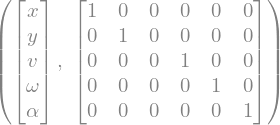

In [36]:
# measurement function, H

H = Matrix([[x], [y], [v], [omega], [alpha]])
H_jacob = H.jacobian(state)
H, H_jacob